In [3]:

!pip install pillow-heif

import os
import shutil
import tensorflow as tf
from google.colab import drive
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from PIL import Image
import pillow_heif


pillow_heif.register_heif_opener()


if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')


SOURCE_PATH = '/content/drive/MyDrive/data'
LOCAL_PATH = '/content/attendance_data_final'

if os.path.exists(LOCAL_PATH):
    shutil.rmtree(LOCAL_PATH)
os.makedirs(LOCAL_PATH, exist_ok=True)

print("Copying dataset ")

# Step 1: Index all files
copy_tasks = []
for root, dirs, files in os.walk(SOURCE_PATH):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.heic')):
            src = os.path.join(root, file)
            rel = os.path.relpath(src, SOURCE_PATH)


            if file.lower().endswith('.heic'):
                rel = os.path.splitext(rel)[0] + ".jpg"

            dst = os.path.join(LOCAL_PATH, rel)
            copy_tasks.append((src, dst))

# Step 2: Copy and Convert
def copy_and_convert(task):
    src, dst = task
    try:
        os.makedirs(os.path.dirname(dst), exist_ok=True)

        if src.lower().endswith('.heic'):
            img = Image.open(src)
            img.save(dst, format="JPEG")
        else:
            shutil.copy2(src, dst)
        return 1
    except:
        return 0

with ThreadPoolExecutor(max_workers=64) as executor:
    list(tqdm(executor.map(copy_and_convert, copy_tasks), total=len(copy_tasks)))

print("Running deep validation ")


bad_files = 0
for root, dirs, files in os.walk(LOCAL_PATH):
    for file in files:
        path = os.path.join(root, file)
        try:

            with Image.open(path) as img:
                img.verify()


            if os.path.getsize(path) == 0:
                raise Exception("Empty file")


            with open(path, 'rb') as f:
                img_bytes = f.read()
                tf.io.decode_image(img_bytes)

        except Exception as e:
            # Delete bad file
            os.remove(path)
            bad_files += 1

print(f"Dataset ready. Deleted {bad_files} unreadable files.")

Copying dataset 


100%|██████████| 2184/2184 [02:17<00:00, 15.86it/s]


Running deep validation 
Dataset ready. Deleted 20 unreadable files.


In [4]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

DATA_DIR = '/content/attendance_data_final'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Load validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
print(f"Classes detected: {len(class_names)}")

# Apply preprocessing
def process_img(img, label):
    return preprocess_input(img), label

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_img).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(process_img).cache().prefetch(buffer_size=AUTOTUNE)

Found 2001 files belonging to 95 classes.
Using 1601 files for training.
Found 2001 files belonging to 95 classes.
Using 400 files for validation.
Classes detected: 95


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential

# Load base model
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False

# Construct final model
inputs = Input(shape=(224, 224, 3))
x = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2)
])(inputs)

x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 92s 396ms/step - accuracy: 0.0945 - loss: 4.6728 - val_accuracy: 0.4525 - val_loss: 2.7020
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.5181 - loss: 2.2554 - val_accuracy: 0.6825 - val_loss: 1.6754
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.7471 - loss: 1.3527 - val_accuracy: 0.7475 - val_loss: 1.2416
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.8325 - loss: 0.9838 - val_accuracy: 0.8200 - val_loss: 0.9483
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.8589 - loss: 0.7192 - val_accuracy: 0.8250 - val_loss: 0.8204
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9113 - loss: 0.5595 - val_accuracy: 0.8400 - val_loss: 0.7425
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9152 - loss: 0.4483 - val_accuracy: 0.8575 - val_loss: 0.6714
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9364 - loss: 0.3860 - val_accuracy: 0.8500 -

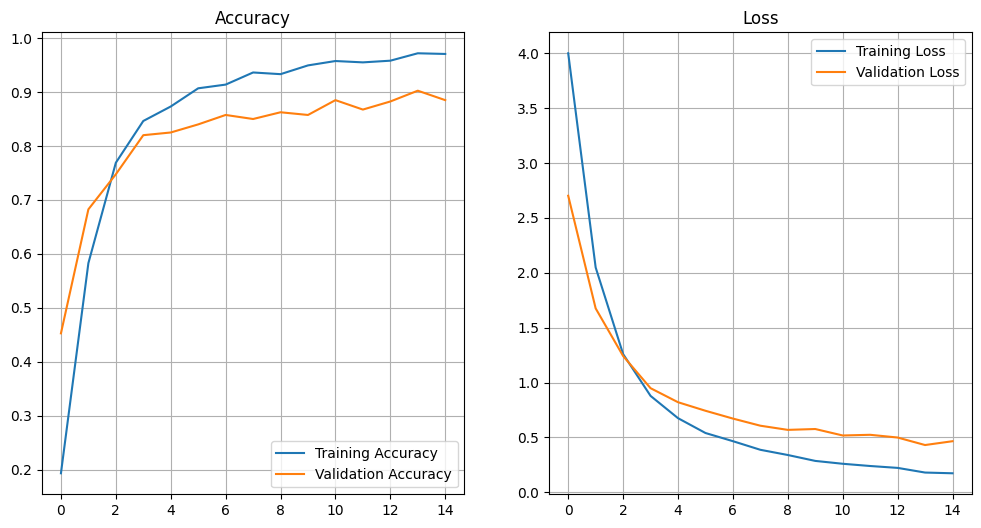

Running prediction check on Groupmates + Random images...


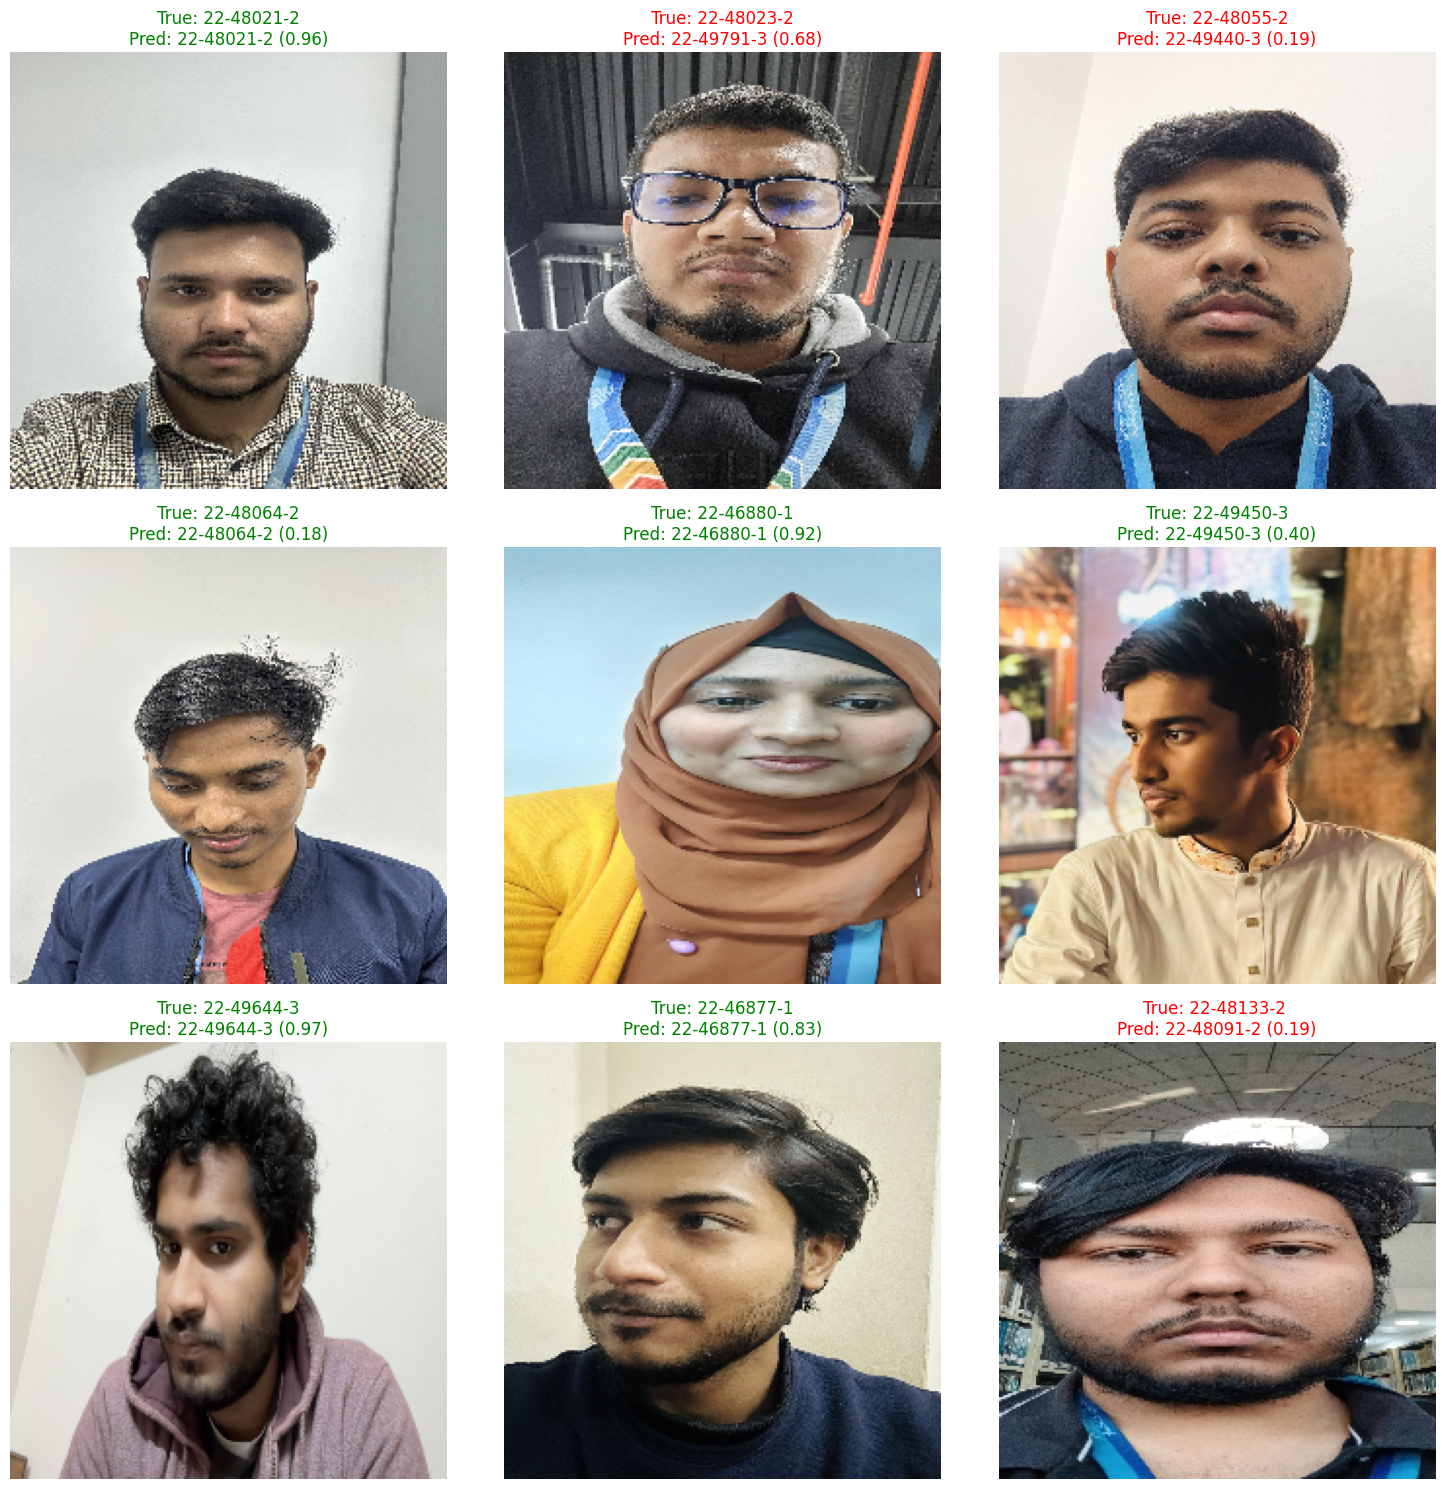

Saving and downloading model...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random
from google.colab import files
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# PLOT GRAPHS
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.grid(True)
plt.show()

# SELECT IMAGES (Groupmates + Random)
print("Running prediction check on Groupmates + Random images...")
plt.figure(figsize=(15, 15))

# Groupmate IDs
TARGET_IDS = ['22-48021-2', '22-48023-2', '22-48055-2', '22-48064-2']

display_list = []
seen_paths = set()

#  Find one image for each Groupmate
for target in TARGET_IDS:
    target_path = os.path.join(DATA_DIR, target)
    if os.path.exists(target_path):
        files_in = [f for f in os.listdir(target_path) if f.lower().endswith(('jpg', 'png', 'jpeg'))]
        if files_in:
            chosen = random.choice(files_in)
            full_path = os.path.join(target_path, chosen)
            display_list.append((full_path, target))
            seen_paths.add(full_path)


all_folders = [f for f in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, f))]

while len(display_list) < 9:
    rand_folder = random.choice(all_folders)
    folder_path = os.path.join(DATA_DIR, rand_folder)
    try:
        files_in_folder = [f for f in os.listdir(folder_path) if f.lower().endswith(('jpg', 'png', 'jpeg'))]
        if files_in_folder:
            rand_file = random.choice(files_in_folder)
            full_path = os.path.join(folder_path, rand_file)

            # Add only if not already in list
            if full_path not in seen_paths:
                display_list.append((full_path, rand_folder))
                seen_paths.add(full_path)
    except:
        continue

# PREDICT & DISPLAY ---
for i, (path, label) in enumerate(display_list):
    # Read
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224)) # Fixed size for display


    img_batch = np.expand_dims(preprocess_input(img_resized.astype(np.float32)), axis=0)

    preds = model.predict(img_batch, verbose=0)
    pred_label = class_names[np.argmax(preds)]
    confidence = np.max(preds)

    # Color Logic
    color = 'green' if label == pred_label else 'red'

    plt.subplot(3, 3, i + 1)
    plt.imshow(img_resized)
    plt.title(f"True: {label}\nPred: {pred_label} ({confidence:.2f})", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

# SAVE & DOWNLOAD
print("Saving and downloading model...")
model.save('attendance_model.h5')

with open('labels.txt', 'w') as f:
    for name in class_names:
        f.write(name + '\n')

files.download('attendance_model.h5')
files.download('labels.txt')